## Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

#---------------------- PREPROCESSING -----------------------------------------
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.impute import SimpleImputer
#---------------------- mMODELS -----------------------------------------
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
#---------------------- PIPELINE -----------------------------------------
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
#---------------------- METRICS -----------------------------------------
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

## Getting the data

In [2]:
df = pd.read_csv("Salary_Data.csv")

In [3]:
df.head()

,YearsExperience,Salary
0,1.1,39343.0
1,1.3,46205.0
2,1.5,37731.0
3,2.0,43525.0
4,2.2,39891.0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 2 columns):
YearsExperience    30 non-null float64
Salary             30 non-null float64
dtypes: float64(2)
memory usage: 608.0 bytes


In [5]:
df.describe()

,YearsExperience,Salary
count,30.000000,30.000000
mean,5.313333,76003.000000
std,2.837888,27414.429785
min,1.100000,37731.000000
25%,3.200000,56720.750000
50%,4.700000,65237.000000
75%,7.700000,100544.750000
max,10.500000,122391.000000


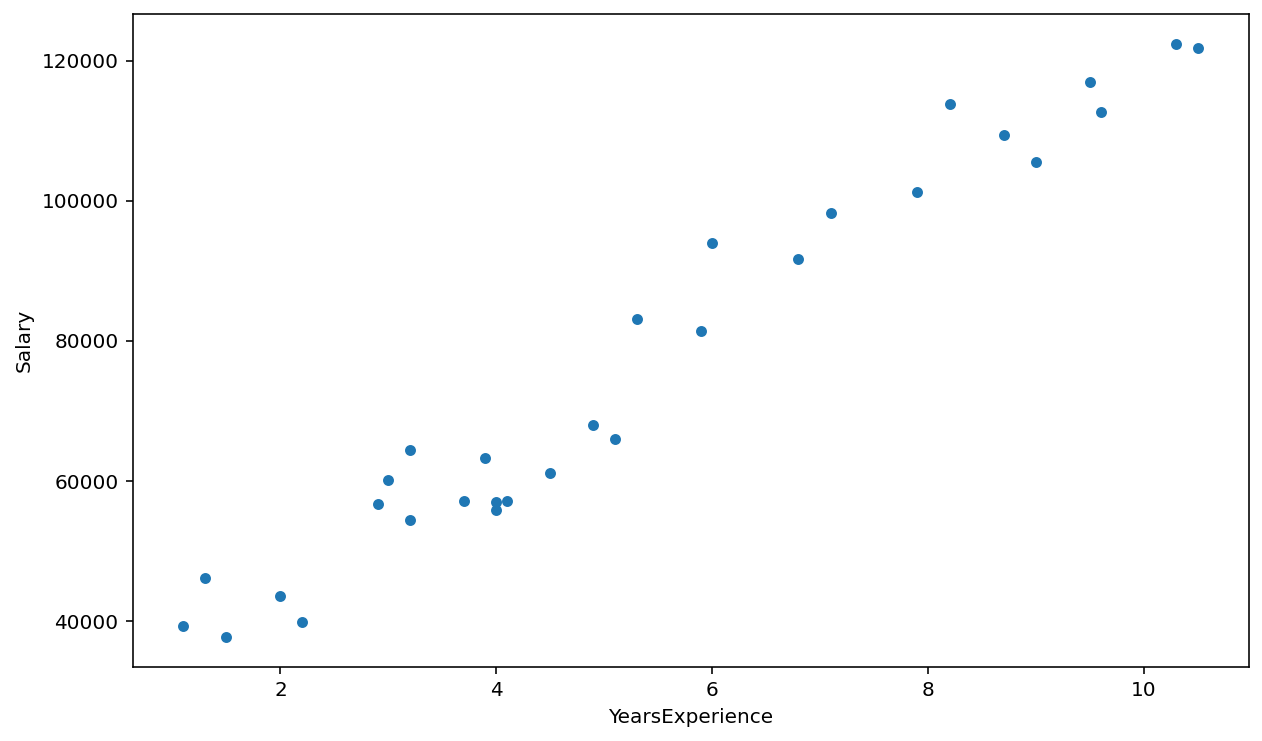

In [6]:
df.plot(x="YearsExperience", y="Salary", figsize=(10,6), kind="scatter")
plt.show()

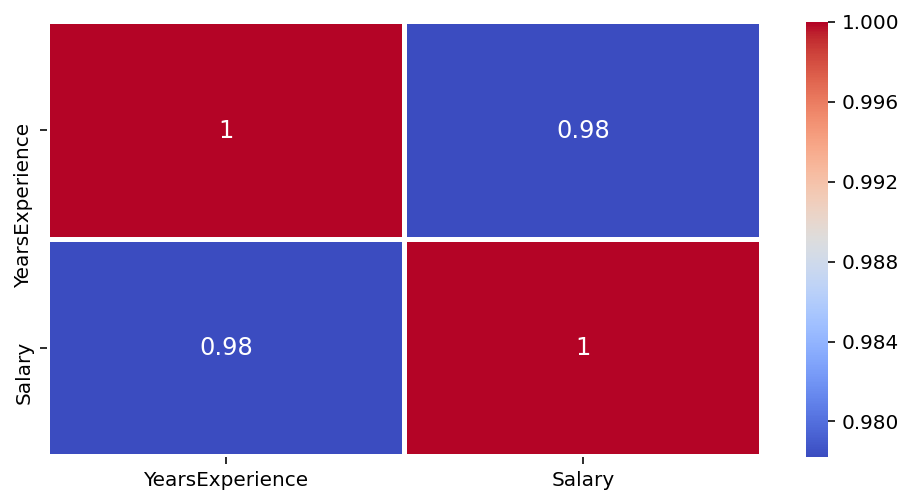

In [7]:
import seaborn as sns
fig, ax = plt.subplots(1,1,figsize=(8,4))
sns.heatmap(df.corr(), annot=True, linewidths=2, annot_kws={"size": 12}, ax=ax, cmap="coolwarm")

## Splitting dataset

In [8]:
X = df.iloc[:, :-1]
y = df.iloc[:, -1]

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1/3, random_state=0)

## Simple Regression Model

In [10]:
model = Pipeline(steps=[
    ("mean_imputer", SimpleImputer(strategy="mean")),
    ("lm", LinearRegression())
])

In [11]:
model.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('mean_imputer',
                 SimpleImputer(add_indicator=False, copy=True, fill_value=None,
                               missing_values=nan, strategy='mean',
                               verbose=0)),
                ('lm',
                 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
                                  normalize=False))],
         verbose=False)

In [12]:
regressor = model[1]
print(f"Slope: {regressor.coef_[0]:.3f}")
print(f"Intercept: {regressor.intercept_:.3f}")

Slope: 9345.942
Intercept: 26816.192


In [13]:
y_pred = model.predict(X_test)

In [14]:
print(f"R2-score: {r2_score(y_test, y_pred):.3f}")
print(f"RMSE-score: {np.sqrt(mean_squared_error(y_test, y_pred)):.3f}")

R2-score: 0.975
RMSE-score: 4585.416


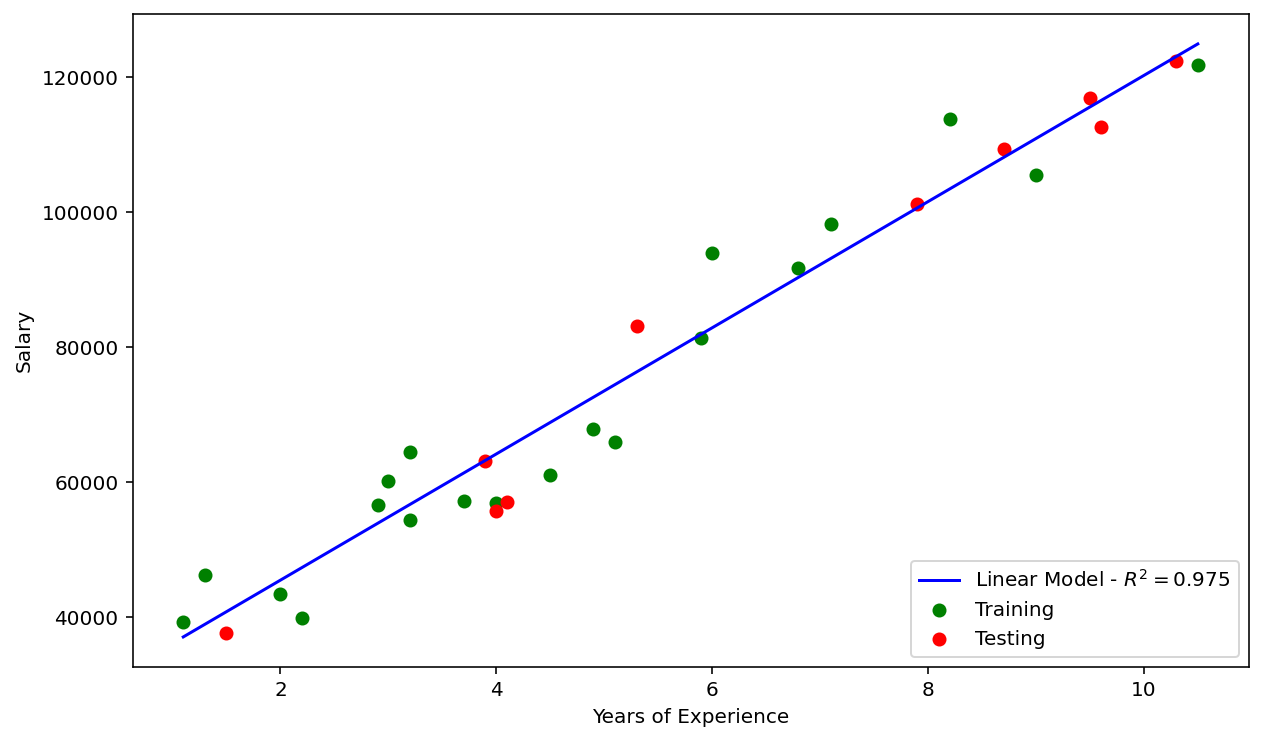

In [15]:
fig, ax = plt.subplots(1,1,figsize=(10,6))
ax.scatter(X_train.YearsExperience.values, y_train.values, c="green", label="Training")
ax.scatter(X_test.YearsExperience.values, y_test.values, c="red", label="Testing")
ax.plot(X.values, model.predict(X), c="blue", label=f"Linear Model - $R^2={r2_score(y_test, y_pred):.3f}$")
ax.set_ylabel("Salary")
ax.set_xlabel("Years of Experience")
plt.legend(loc=4)
plt.show()

## Multiple Regression Model

In [16]:
df = pd.read_csv("50_Startups.csv")

In [17]:
df.head()

,R&D Spend,Administration,Marketing Spend,State,Profit
0,165349.20,136897.80,471784.10,New York,192261.83
1,162597.70,151377.59,443898.53,California,191792.06
2,153441.51,101145.55,407934.54,Florida,191050.39
3,144372.41,118671.85,383199.62,New York,182901.99
4,142107.34,91391.77,366168.42,Florida,166187.94


In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 5 columns):
R&D Spend          50 non-null float64
Administration     50 non-null float64
Marketing Spend    50 non-null float64
State              50 non-null object
Profit             50 non-null float64
dtypes: float64(4), object(1)
memory usage: 2.1+ KB


In [19]:
df.describe()

,R&D Spend,Administration,Marketing Spend,Profit
count,50.000000,50.000000,50.000000,50.000000
mean,73721.615600,121344.639600,211025.097800,112012.639200
std,45902.256482,28017.802755,122290.310726,40306.180338
min,0.000000,51283.140000,0.000000,14681.400000
25%,39936.370000,103730.875000,129300.132500,90138.902500
50%,73051.080000,122699.795000,212716.240000,107978.190000
75%,101602.800000,144842.180000,299469.085000,139765.977500
max,165349.200000,182645.560000,471784.100000,192261.830000


In [20]:
df.describe(include="object")

,State
count,50
unique,3
top,California
freq,17


### Splitting the Dataset

In [21]:
X = df.iloc[:, :-1]
y = df.iloc[:, -1]

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

### Pipeline

In [23]:
qualitative = [column for column in X.columns if X[column].dtype=="object"]
quantitative = [column for column in X.columns if column not in qualitative]

In [24]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    
    def __init__(self, columns):
        self.columns = columns
        
    def fit(self, data, labels=None):
        return self
    
    def transform(self, data):
        assert isinstance(data, pd.DataFrame), "Please insert a Pandas DF"
        return data[self.columns]

In [25]:
pipe_numerical = Pipeline(steps=[
    ("quant_selector", ColumnSelector(columns=quantitative)),
    ("mean_imputer", SimpleImputer(strategy="mean"))
])

pipe_categorical = Pipeline(steps=[
    ("cat_selector", ColumnSelector(columns=qualitative)),
    ("mode_imputer", SimpleImputer(strategy="most_frequent")),
    ("one_hot_encoder", OneHotEncoder(drop="first")) #ONLY WHEN COLLINEARITY CAN HAPPEN
])

preprocessor = FeatureUnion(transformer_list=[
     ("cat_preprocessor", pipe_numerical),
     ("num_preprocessor", pipe_categorical)
])

##### a) Linear Regression

In [26]:
model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("lr", LinearRegression())
])

In [27]:
model.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('preprocessor',
                 FeatureUnion(n_jobs=None,
                              transformer_list=[('cat_preprocessor',
                                                 Pipeline(memory=None,
                                                          steps=[('quant_selector',
                                                                  ColumnSelector(columns=['R&D '
                                                                                          'Spend',
                                                                                          'Administration',
                                                                                          'Marketing '
                                                                                          'Spend'])),
                                                                 ('mean_imputer',
                                                                  SimpleImputer(add_ind

In [28]:
y_pred = model.predict(X_test)

In [29]:
print(f"R2-score: {r2_score(y_test, y_pred):.3f}")
print(f"RMSE-score: {np.sqrt(mean_squared_error(y_test, y_pred)):.3f}")

R2-score: 0.935
RMSE-score: 9137.990


+ BACKWARD ELIMINATION

In [30]:
import statsmodels.api as sm

Adding a column of 1s in the beginning:

In [31]:
X_train_final = preprocessor.fit_transform(X_train).toarray()
X_train_stat = np.append(values=X_train_final, arr=np.ones((X_train_final.shape[0], 1)), axis=1)

In [32]:
X_test_final = preprocessor.transform(X_test).toarray()
X_test_stat = np.append(values=X_test_final, arr=np.ones((X_test_final.shape[0], 1)), axis=1)

Process:

In [33]:
X_train_opt = X_train_stat[:, [0,1,2,3,4,5]]
regressor_OLS = sm.OLS(endog=y_train, exog=X_train_opt).fit()

In [34]:
regressor_OLS.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Profit   R-squared:                       0.950
Model:                            OLS   Adj. R-squared:                  0.943
Method:                 Least Squares   F-statistic:                     129.7
Date:                Thu, 19 Mar 2020   Prob (F-statistic):           3.91e-21
Time:                        16:37:14   Log-Likelihood:                -421.10
No. Observations:                  40   AIC:                             854.2
Df Residuals:                      34   BIC:                             864.3
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       4.255e+04   8358.538      5.091      0.000    2.56e+04    5.95e+04
x1             0.7735      0.055     14.025      0.000       0.661       0.886
x2             0.0329      0.066      0.495      0.624      -0.102       0.168
x3             0.0366      0.019      1.884      0.068      -0.003       0.076
x4          -959.2842   4038.108     -0.238      0.814   -9165.706    7247.138
x5           699.3691   3661.563      0.191      0.850   -6741.822    8140.560
==============================================================================
Omnibus:                       15.823   Durbin-Watson:                   2.468
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               23.231
Skew:                          -1.094   Prob(JB):                     9.03e-06
Kurtosis:                       6.025   Cond. No.                     1.49e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.49e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

###### b) Polynomial Regression

In [35]:
model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("poly", PolynomialFeatures(degree=2)),
    ("lr", LinearRegression())
])

In [36]:
model.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('preprocessor',
                 FeatureUnion(n_jobs=None,
                              transformer_list=[('cat_preprocessor',
                                                 Pipeline(memory=None,
                                                          steps=[('quant_selector',
                                                                  ColumnSelector(columns=['R&D '
                                                                                          'Spend',
                                                                                          'Administration',
                                                                                          'Marketing '
                                                                                          'Spend'])),
                                                                 ('mean_imputer',
                                                                  SimpleImputer(add_ind

In [37]:
y_pred = model.predict(X_test)

In [38]:
print(f"R2-score: {r2_score(y_test, y_pred):.3f}")
print(f"RMSE-score: {np.sqrt(mean_squared_error(y_test, y_pred)):.3f}")

R2-score: 0.839
RMSE-score: 14367.783
